# ガウス過程と機械学習

In [25]:
using Distributions
using Plots
using Printf

In [2]:
struct GaussianKernel{T <: Real}
    theta1::T
    theta2::T
    function GaussianKernel(theta1::T, theta2::T) where {T <: Real}
        theta2 == 0 ? throw(DomainError(theta2, "theta2 must not be zero")) : new{T}(theta1, theta2)
    end
end

function kernel(k::GaussianKernel, x1::T, x2::T) where {T <: Real}
    k.theta1 * exp(- abs(x1 - x2)^2 / k.theta2)
end

function cov(k::GaussianKernel, x::Vector{T}) where {T <: Real}
    n = Base.length(x)
    c = zeros(n, n)
    for i in 1:n
        for j in 1:n
            c[i, j] = gk.theta1 * exp(- abs(x[i] - x[j])^2 / gk.theta2)
        end
    end
    c
end

cov (generic function with 1 method)

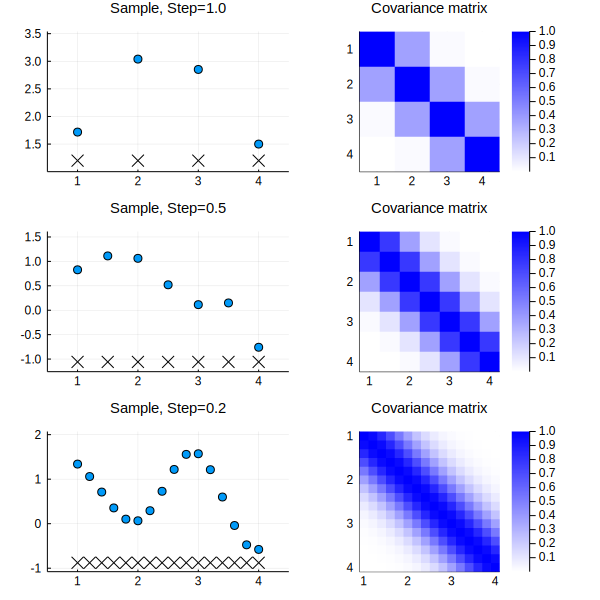

In [32]:
plts = []

xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]
gk = GaussianKernel(1, 1)

for (x, y) in zip(xx, yy)
    x1 = collect(x)
    k = cov(gk, x1)
    n = Base.length(x1)
    sample = rand(MvNormal(zeros(n), k))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "", 
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, k, 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])